# Earthquakes Data Analysis

In this project we are going study a dataset of earthquakes occurred in a time window of almost 30 years in South California. The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of each earthquakes. Moreover it is provided also a column indicating for each event what was the previous event from a causal point of view; however it is not known with which criteria this information is computed, thus we are going to rely only partially on it. 

# 0 - Understanding data

First of all we took a numerical look at the dataset through pandas methods, in order to understand which kind of data we are dealing with.

In [1]:
import numpy as np
from scipy import linalg as la
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # <- relevant

In [2]:
import importlib        # 'importlib.reload(E)' to reload the module
# This is the library containing the functions that we are going to use in this notebook
import Earthquakes as E 

In [3]:
df = E.ImportDataset()

In [4]:
df.head() #show first 5 events

,event,prev_event,time,magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


We can see that the range of magnitudes is [2, 7.3] 
and that the measurement of time starts from 0 with the first event.


In [5]:
df.describe()

,event,prev_event,time,magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


The dataset is composed by 110271 events.

In [6]:
df[df['magnitude']>6].sort_values(by = 'magnitude', ascending = False)

,event,prev_event,time,magnitude,x,y,z
39805,39805,39804,3.309144e+08,7.30,-2341818,-4710335,3575181
100065,100065,100062,8.915162e+08,7.20,-2294542,-4855348,3390238
75422,75422,75419,5.612489e+08,7.10,-2316706,-4693410,3609984
58367,58367,-1,3.799916e+08,6.70,-2508327,-4610300,3567642
22089,22089,21867,1.859399e+08,6.60,-2322573,-4795291,3462353
89331,89331,-1,6.932159e+08,6.48,-2662869,-4420508,3708948
39859,39859,39858,3.309257e+08,6.30,-2373276,-4692488,3573922
21867,21867,21866,1.858990e+08,6.20,-2316585,-4796535,3470023
37455,37455,37449,3.251864e+08,6.10,-2335795,-4723356,3549940
55532,55532,-1,3.588626e+08,6.10,-2364815,-4481227,3839436


There are only 12 earthquakes with magnitudes higher than 6.

Introducing a little bit of notation we name:
* "ancestor" (or parent) of an event $i$ his previous event prev_event$(i)$;
* "prime events" the events whose previous event is -1 (that is, no ancestor);
* "following events" two events whose IDs are $i$ and $i+1$;
* "consequent events" two events that are one the parent of the other (we will call the latter one "child").


Interestingly, we can see that not all the greatest earthquakes are prime events.

# 1 - Data visualization

Now we deepen our understanding of the main variables contained in the dataset with a series of graphical methods.

## 1.1 - Time distribution

First of all we plot the time of occurrence of each event.

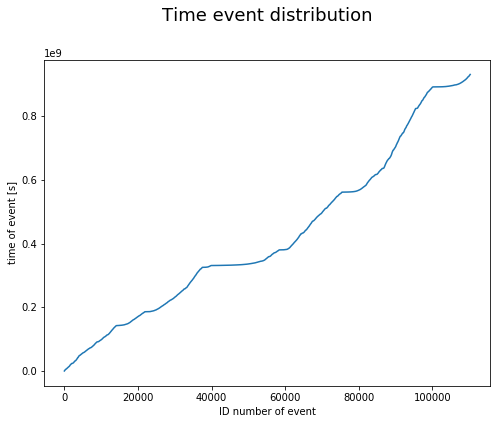

Number of years between the first and the last event:  29


In [7]:
E.TimeEventPlot(df)
n_years = int(df['time'].max()//(86400*365))
print("Number of years between the first and the last event: ", n_years)

We can notice that the trend is monotonically increasing, but there are some points where the curve is steepest than others. This is probably due to the fact that earthquakes usually occur clustered in swarms, thus there are periods in which a lot of events happen in a very short time (this is when the curve bends horizontally) and periods between swarms where very few events occur (steepest parts of the curve).

## 1.2 - Magnitude distribution

Here we can easily see how the magnitude is distributed as an exponential $e^{-m}$. 

This implies that we can't study directly from a statistical point of view the subset of earthquakes of magnitude above a high threshold (e.g. magnitude greater than 5).

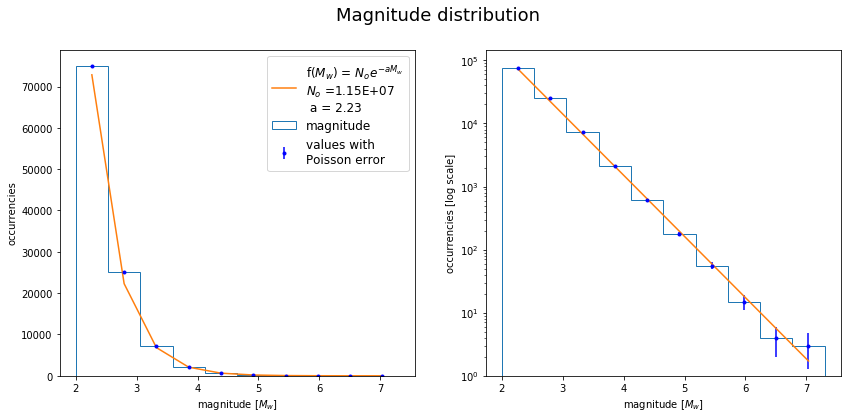

In [8]:
E.MagnitudeDistribution(df)

## 1.3 - Spatial distribution 

The plot below is done with the graphic library plotly. Markers size and color depend on an exponential scale from the magnitude of the events and events with a magnitude under a certain threshold are not shown for the sake of clarity.

In [9]:
import plotly as py # main class
import plotly.graph_objs as go # graphical objects
py = py.offline
py.init_notebook_mode(connected=True)

m_bar = 3.5
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
magnitude = dfm['magnitude']

trace1 = go.Scatter3d(x=x_coord, y=y_coord, z=z_coord, mode='markers', opacity = 0.7,
                     marker=dict(size=np.exp(magnitude)/np.exp(3.5), colorscale='Electric', 
                     color=np.exp(magnitude)/np.exp(magnitude).max(), line=dict(width=0)))

data = [trace1]
layout = go.Layout(autosize=False, width=800, height=1000)
fig = go.Figure(data=data)
py.iplot(fig)

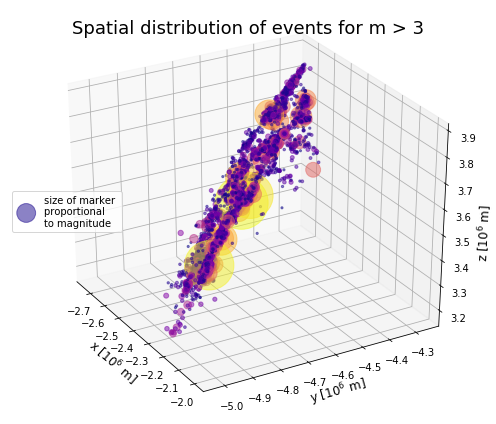

In [10]:
E.SpatialDistribution(df) 

### 1.3.1 PCA for spatial distribution

The graphics seen above suggest that all the events are distributed on a plane. This means that they could be represented without much loss of information using just two coordinates; in order to do this we perform Principal Component Analysis (PCA).

In [11]:
X = df[['x','y','z']].values.T
X = X.astype("float64")

# centering and rescaling the coordinates
for i in range(3):
    X[i] = (X[i] - X[i].mean())/X[i].std()

As we can see below, the two largest eigenvalues can account for 99.9% of the total variability of the spatial coordinates; thus we can effectively conclude that the events are located on a plane.

Another interesting thing to notice is that the ratio between the largest eigenvalue and the second one is 0.8, meaning that the events on the plane are not uniformly distributed, but follow a more stretched shape (as we could already see in the 3D plot above).

In [12]:
# PCA 
C = np.cov(X)
U, spectrum, Vt = la.svd(C)
print ('Spectrum: ', spectrum,'\n')
perc_expl2 = (spectrum[0] + spectrum[1]) / spectrum.sum()
print('Percentage of the total variability explained considering the two main features: %.2f \n'% (perc_expl2*100))
print('Ratio between the first eigenvalue and the total sum of eigenvalues: ', round(spectrum[0]/spectrum.sum(),2))

Spectrum:  [2.40189791e+00 5.96194962e-01 1.93433620e-03] 

Percentage of the total variability explained considering the two main features: 99.94 

Ratio between the first eigenvalue and the total sum of eigenvalues:  0.8


In the following panels we represent the two-dimensional projections of the spatial coordinates of the dataset both for the $x,y,z$ frame and the $v_0, v_1, v_2$ frame (e.g. the one in the PCA coordinates); in the latter one we can see how the $v_2$ component is almost constant and all the relevant information is contained in the scatterplot $v_0$ vs $v_1$, that represents the projection of the original data along the eigenvectors associated to the two largest eigenvalues found in the PCA procedure. 

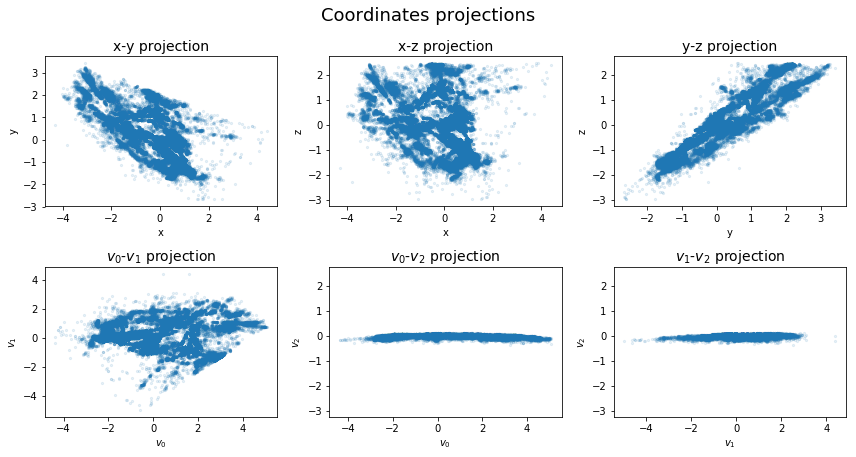

In [13]:
Xp = np.dot(Vt,X)
E.PCA_plot(X, Xp)

Going back to the $x,y,z$ frame, we can see in a trasversal view how the plane that corresponds to the eigenspace of the two largest eigenvectors fits the data. This is further evidence of the PCA efficacy.

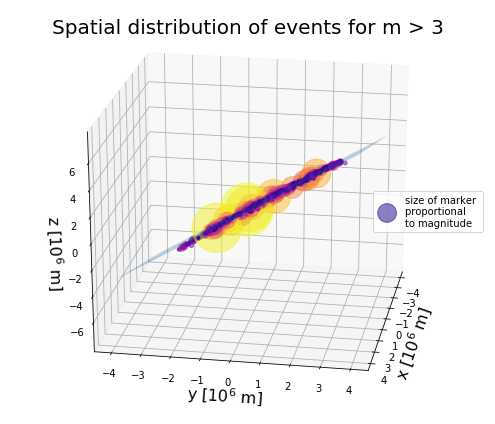

In [14]:
[v1, v2, v3] = Vt
normal = v3  
E.TrasversePlanePlot(df, normal)

Finally we plotted a heatmap of the events using as coordinates the first and the second principal components, to visualize the density of events in those coordinates. The color is brighter where the density is higher, with a scale of colors that is logaritmic in the occurrencies of each cell. 

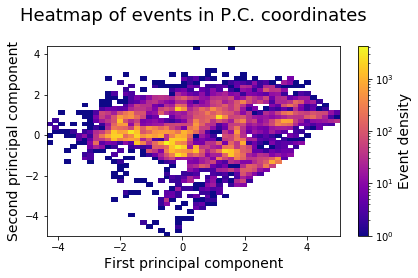

In [15]:
E.HeatmapCoordinatePlot(Xp)

## 1.4 - Tree architecture

Here we want to exploit the information contained in the 'prev_event' column in order to be able to compute quantities such as distance and waiting time between an event and his ancestor.

First of all we iteratively created a nested dictionary, containing as keys the IDs of the primes events and as values a dictionary with:
* the "depth" of the event in the cause-effect chain (i.e. 0 for the prime events, 1 for the ones caused by them, 2 for the ones caused by events of depth 1 and so on so forth);
* the "children" of that event, i.e. the events that have as prev_event the ID of the event considered; "children" value contains itself a dictionary like the one just described for the prime events, hence the nested structure.

In [29]:
def evees_light(df, index=-1, depth=0):
    dataset = {}
    df_filtered = df[df["prev_event"]==index]
    lenght =  df_filtered.shape[0]
    for i in range(lenght):
        event = df_filtered.iloc[i]
        dataset[str(int(event["event"]))] = {"depth" : depth}
        dataset[str(int(event["event"]))]["children"] = evees_light(df, index=int(event["event"]), depth = depth + 1)
    return dataset

Then we mapped the dictionary so obtained in a list of dictionaries, whose indexes are the depth of the events (ranging from 0 to max_depth, that is unknown a priori); the entry of the list of index $i$ is a dictionary that has as keys the IDs of the events of $depth = i$ and as values the IDs of its children.

In [30]:
def write_dict_array(dataset, dict_array):
    for k in dataset.keys():
        depth = dataset[k]['depth']
        # k is the keyword, children_ids are the values
        if len(dict_array) < depth + 1 :
            while len(dict_array) < depth + 1:
                dict_array.append({})
        else:
            dict_array[depth][k] = list(dataset[k]['children'].keys())
        if len(list(dataset[k]['children'].keys())) != 0:
            write_dict_array(dataset[k]['children'], dict_array)

In [31]:
tree_dataset = evees_light(df)
v_dict = [{}]
write_dict_array(tree_dataset, v_dict)

Now we use the list of dictionaries to add the depth and the number of children (or number of edges if we think of the dataset as an oriented graph) of each event by adding two columns to the original dataset.

In [32]:
N = df.shape[0]
edges = np.zeros(N)
depths = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        edges[int(k)] = len(v_dict[d][k])
        depths[int(k)] = d
        
        

df['edges'] = edges
df['depth'] = depths

From the new features we can see an interesting thing: the event with the highest magnitude $(7.3)$ is not prime 
(because it hasn't prev_event = $-1$), but it happend after a concatenation of $11$ earthquakes and subsequently 
caused other $4209$ events!

In [33]:
df[df['magnitude'] == 7.3]

,event,prev_event,time,magnitude,x,y,z,edges,depth
39805,39805,39804,3.309144e+08,7.3,-2341818,-4710335,3575181,4209.0,11.0


Furthermore we can see that depth isn't a good indicator of magnitude and that in fact one can't find any relation
between the two.

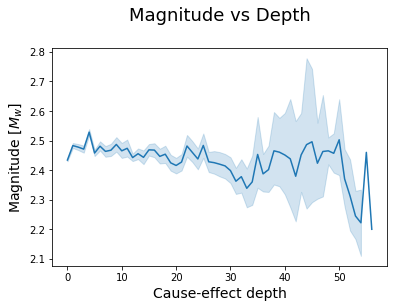

In [34]:
E.MagnitudeDepthPlot(df)

As we could expect, events with higher magnitudes have much more edges than the ones with lower magnitudes. 
In fact the dependence is exponential with $m$.


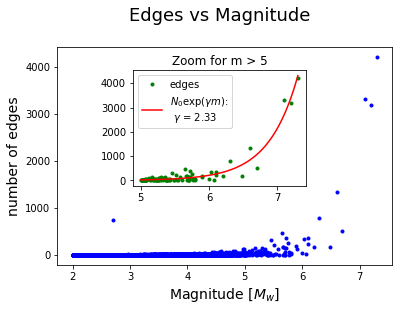

In [35]:
E.EdgesMagnitudePlot(df)

Again depth isn't a good indicator of edges (as it wasn't for magnitude).

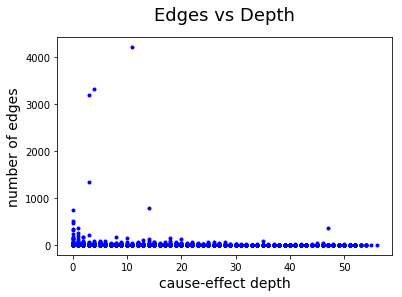

In [36]:
E.EdgesDepthPlot(df)

# 2 - Distribution of waiting time 

In this section we are interested in studying the distribution of the time that passes from the occurrence of one event to the following (also known as waiting time $t_w$), conditioned the fact that both the earthquakes have magnitude above a certain threshold $m$.
Thus each distribution of waiting times $P_m(t_w)$ will depend on the parameter $m$.

### Histogram binning

We constructed the histogram for this distribution expecting some kind of powerlaw, thus we decided to take the bin extremes so that they were evenly spaced in the logarithmic space. 

Then for converting the countings of the bins in a probability density estimate it holds:

$ p(t)dt = P(t) \propto n(t)$, with $dt$ the bin width, $n(t)$ the counts of bin in position $t$ and $p(t)$ the probability density that we want to estimate.

Thus to compute $p(t)$ we have to divide each entry of the histogram for the width of its bin and finally normalize the area of the histogram to 1. 
The errors associated to the $p(t)$ are just given by the propagation of the error of $n(t)$ that is taken as $\sqrt {n(t)}$ because the entries of an histogram follow a poissonian process:

$p = n/(dt*area) \rightarrow  \sigma(p) = \sigma(n)/(dt*area) = \sqrt n/(dt*area)$

OBS: the first bin is somehow special because the left extreme is $t = 0$ and it can't be taken its logarithm, thus we choose the right extreme $t_1^{(r)}$ of the first bin with a criteria based on a quantile and then compute all the others bins from it, finally concatenating $t_1^{(l)} = 0$ as left extreme of the first bin in the normal space. For this reason the countings of the first bin are always a bit unreliable and out-of-trend, thus we ignore them in the fitting procedure.

### Cutoff detection

Observing the points $(t_c,p(t_c))$ in the log-log space, where $t_c$ is the center of each bin, it can be noticed that there trend is linear up to a certain $t = t_{cut}$ and then it bends down like if it is suppressed. This phenomenon called cutoff it depends on the magnitude and one can try to see if the system presents some kind of scaling property. The idea is that if the cutoff time is the only characteristic time of the system (powerlaws don't have a centroid and are long tailed distributions, so they don't have any intrinsic length/time scale), normalizing all distribution so that all the cutoffs become the same should automatically collapse all the distribution to a single one, because originally they represent the same system but on a different "scale". Of course this would work only if the underlying distribution is the same, so it has to be the same exponent $p$ for all the magnitudes.

Now that it is understood the importance of the cutoff detection, we breafly describe the idea of the algorithm that we implemented in order to detect it automatically.

Basically we want to say that the cutoff is the point in the middle between the last alligned point and the first one misalligned. A natural way to measure the misallignment of the $i-th$ point is the ratio between how distant are on average the $i-1$ points before it w.r.t. the straight line fitting them and the distance of the $i-th$ point from the same line. We compute this ratio for each point starting from at least $P_0 = 5$ points and then take as first misalligned point the one with the highest ratio.

We choosen to study the data for $m$ between $2$ and $4.5$, because above $5$ we get just $104$ samples 
and there isn't enough information to fit anything but the initial peak of the distribution.

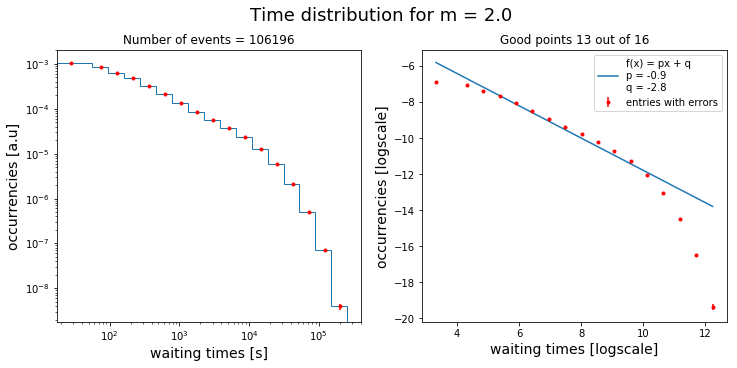

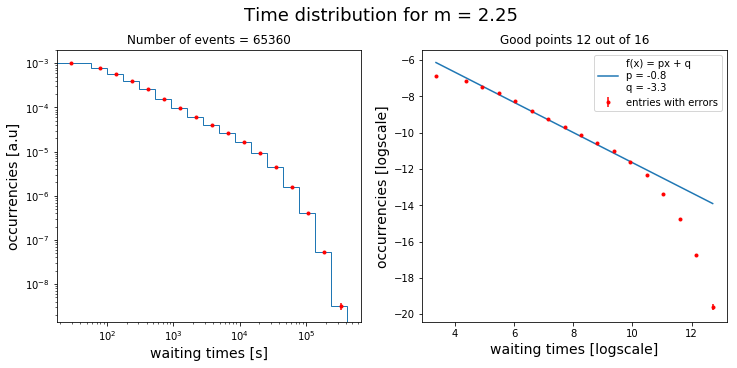

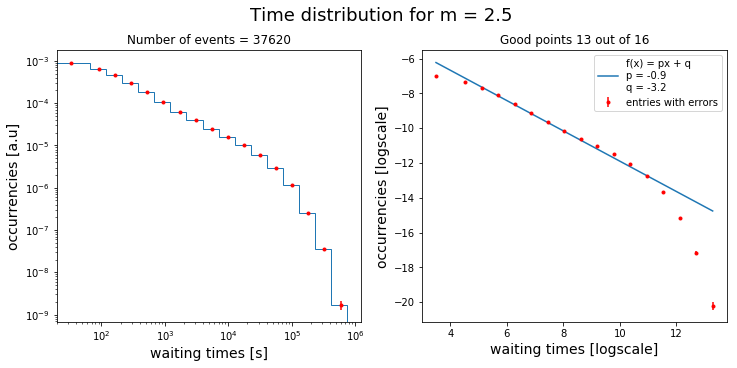

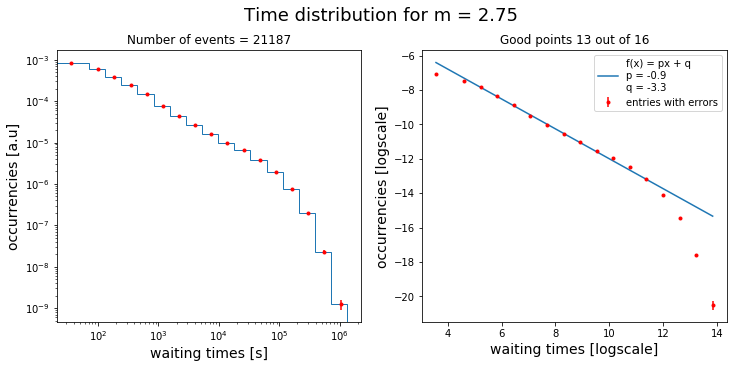

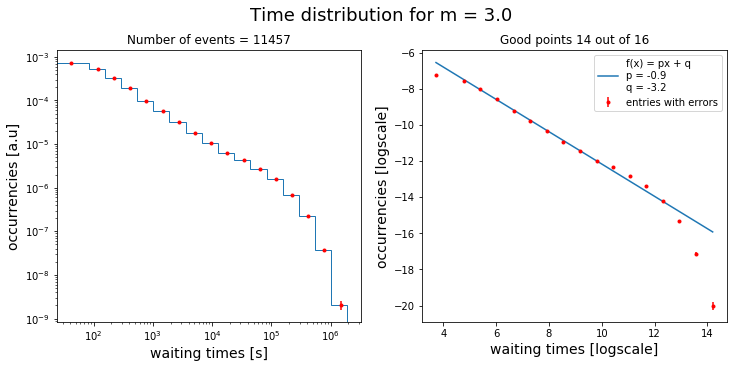

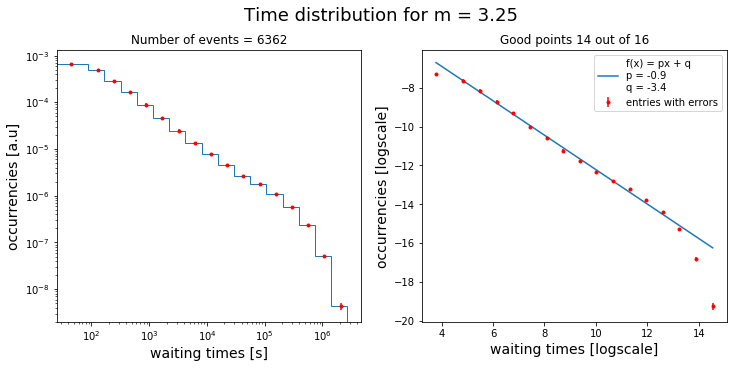

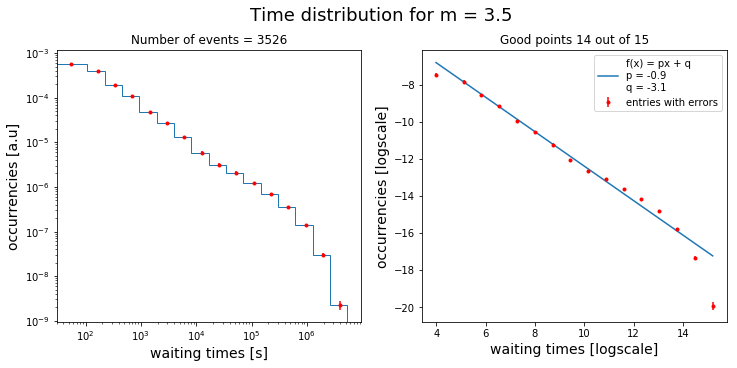

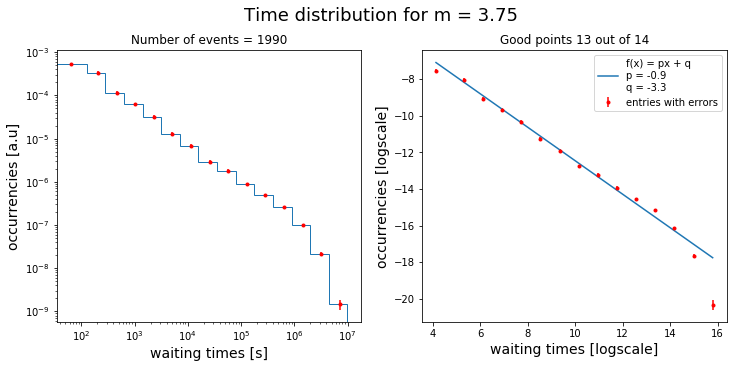

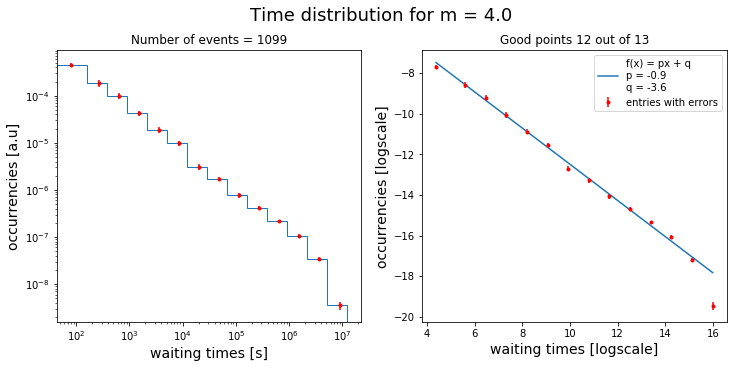

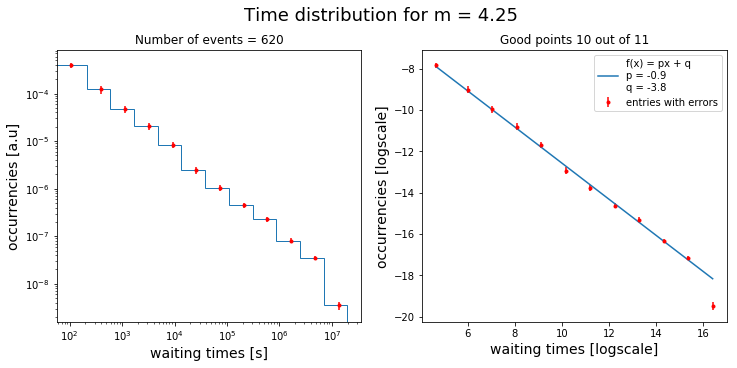

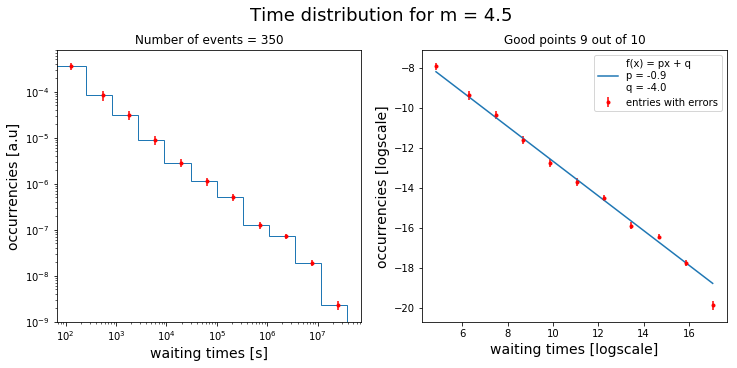

In [16]:
ms1 = np.linspace(2,4.5,11)
p_time = np.zeros(len(ms1))
q_time = np.zeros(len(ms1))
p_t_errors = np.zeros(len(ms1))
cut_times = np.zeros(len(ms1))

for i in range(len(ms1)):
    m = ms1[i]
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    # eliminating a couple of anomalous events
    temp = time_d[time_d != time_d.max()]
    maximum = temp.max()
    if time_d.max()*3/4 > maximum:
        time_d = temp
    title = 'Time distribution for m = ' + str(m)
    p_time[i], q_time[i], p_t_errors[i], cut_times[i] = E.plot_powerlaw_hist(time_d, rescaling = False, 
                                                                   density = True, cut_off = True, P0 = 5, suptitle = title)

From the analysis of the p exponent of $P(t) \propto t^p$ we can't find any significant pattern in the dipendence from the magnitude.

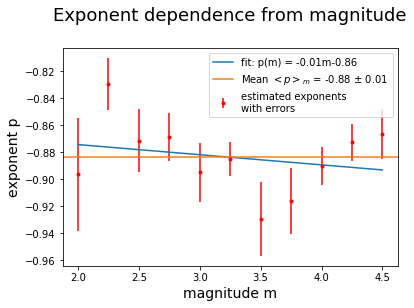

In [17]:
E.EsponentMagnitudePlot(ms1, p_time, p_t_errors)

Instead the cut-off time has an exponential dependence from the magnitude. We will see in the last section how this relation can be used for a rescaling procedure that collapses the distributions of the waiting times for each magnitude to a single, magnitude-independent, distribution.

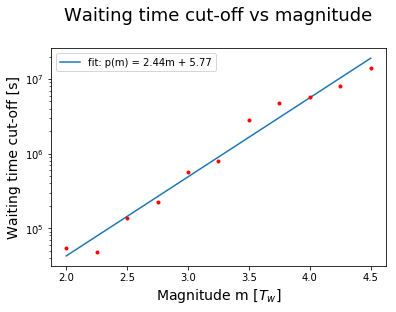

In [18]:
cut_times, scaling_params = E.WaitingMagnitudePlot(ms1, cut_times)

### 2.2 - Waiting time distribution between consequent events 

We now analyze the distribution of waiting times but considering only the waiting times between an event and his ancestor.

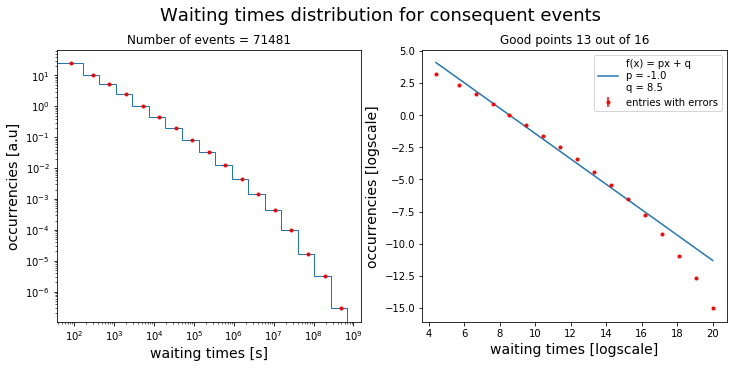

In [37]:
E.WaitingTimeConsequentEvents(df, v_dict)

We can see that the waiting time distribution of consequent events displaces a behaviour similar to the more general case seen above, i.e. a power law with a cut-off, but with an exponent $p$ greater in absolute value, meaning that the powerlaw is sharper around the origin in this case. We could expect this because it is more likely that consequent events are relatively closer to each other in terms of waiting time than two uncorrelated events and if the distribution remains a powerlaw, this implies a sharper distribution.

# 3 - Distance distribution between events

In this section we want to study a similar distribution, namely the distribution of the distance between two following events, conditioned the fact that both the earthquakes have magnitude above a certain threshold $m$.
We will refer to it as $P_m(r)$ and again it will depend on the parameter $m$.

Unlike the previous case, with this kind of distribution we found that drawing the bin's widths from a evenly spaced sequence in the logaritmic space was highly unstable. This is probably due to the fact that this distribution isn't monotonically decreasing, but there is a peak "inside" the first bin.

Thus we started by visualizing the distribution with a histogram with bins of constant width and then we tackled the problem with a different approach, by decomposing the distance distribution in two sub-distributions that could explain it.

For m = 2.0 and N = 106197 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9


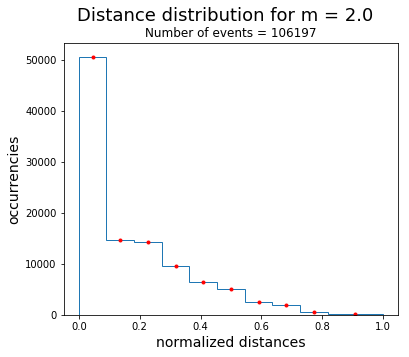

For m = 2.5 and N = 37621 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87


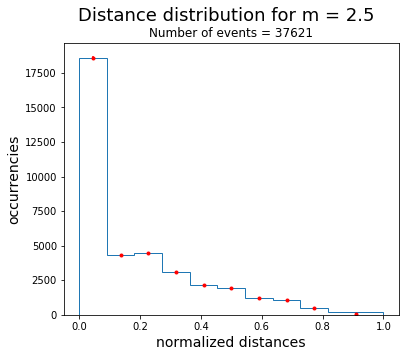

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


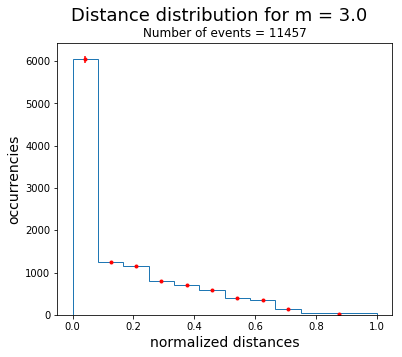

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


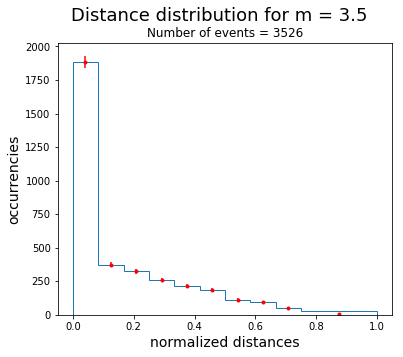

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


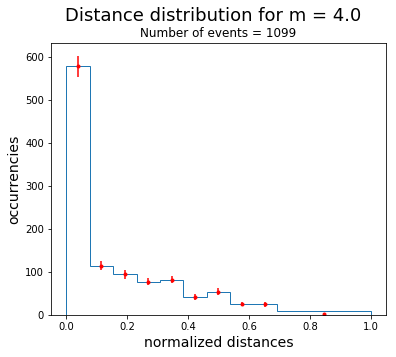

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 9: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 8: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 7: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 6: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 5: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


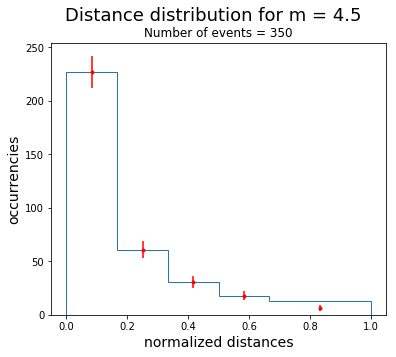

In [19]:
ms = np.linspace(2,4.5,6)
E.DistanceDistributionPlot(df, ms) 

To investigate if the distribution has an internal structure, like a consequential order, we shuffled all the raws of the dataset and recomputed the histograms. In the graphics below we can see that the distribution changes, sign that the order of the events is indeed relevant and not considering it in the analysis would lead to qualitatively different results.

For m = 2.0 and N = 106197 the minimum number of events in the tail required is : 106
Minimum accuracy expected : 0.9


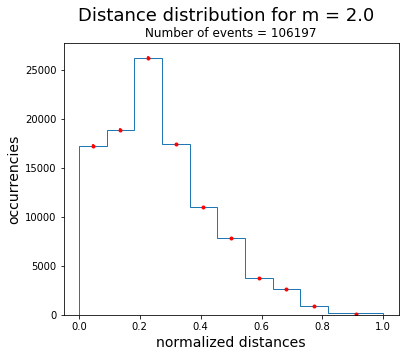

For m = 2.5 and N = 37621 the minimum number of events in the tail required is : 62
Minimum accuracy expected : 0.87


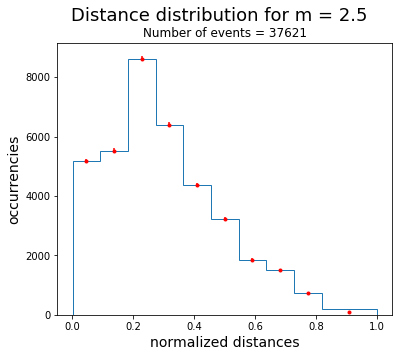

For m = 3.0 and N = 11457 the minimum number of events in the tail required is : 31
Minimum accuracy expected : 0.82


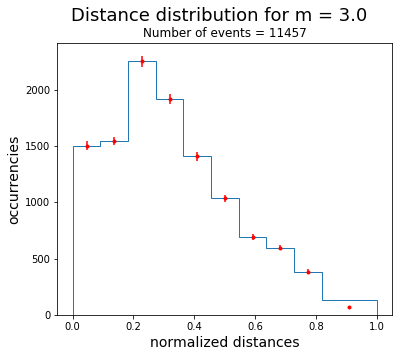

For m = 3.5 and N = 3526 the minimum number of events in the tail required is : 15
Minimum accuracy expected : 0.74


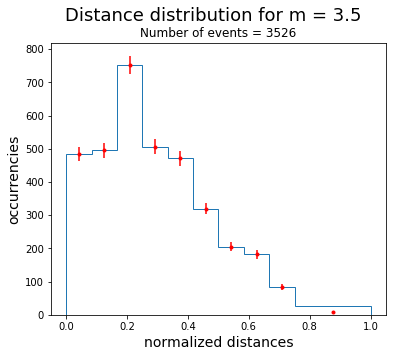

For m = 4.0 and N = 1099 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


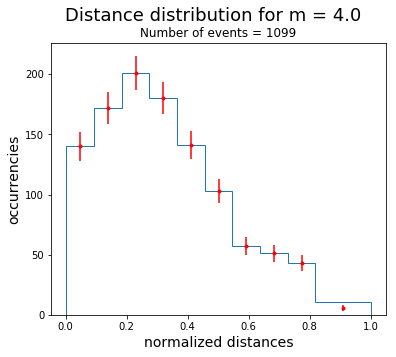

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
-> reducing the final number of bins to 9: 

For m = 4.5 and N = 350 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68


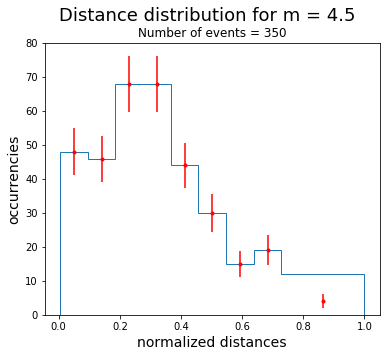

In [20]:
ms = np.linspace(2,4.5,6)
df1 = df.sample(frac = 1).reset_index(drop = True)
E.DistanceDistributionPlot(df1, ms) 

## Distance distribution decomposition

The distributions that can be seen above can't be easily identified with a known distribution (decreasing exponential, powerlaw), thus we decomposed it in two different contributions using our knowledge about how the earthquakes relate one to each other. In fact they can be studied as a sequence of independent events (the ones with prev_event = -1), each one of them causing a cluster of related events, as we have already seen in the study of the tree architecture of the dataset.

Thus we expect that the overall distance distribution is the result of the following process:
* each earthquake has a magnitude distributed as $P(m) \propto e^{-am}$, $a > 0$;
* each earthquake causes N events depending on his magnitude with distibution $N(m) = N_0e^{\gamma m}$, $\gamma > 0$;
* prime events are independent one from another and are distributed with a certain distance distribution $P'_m(r)$;
* consequent events (i.e. all the events that are not prime) have a distance $r$ from the event that caused them, that is distributed with another distribution $P^{cons}(r)$ (here we drop the m-dependence, because a threshold on $m$ would break the chain of cause-effect, that is univoque);

This four distributions, if known, could reproduce the probability distribution of the distance between two "following" events; thus in this section we are going to study $P'_m(r)$ and $P^{cons}(r).$

## 3.1 - Distance distribution between prime events

We plotted for each magnitude the normalized distances between two events and fitted them with a continuous Poisson distribution, that is usually used for independent event with a well-defined expected value.

For m = 2.0 and N = 37157 the minimum number of events in the tail required is : 37
Minimum accuracy expected : 0.84
Number of bins merged into the tail: 1 



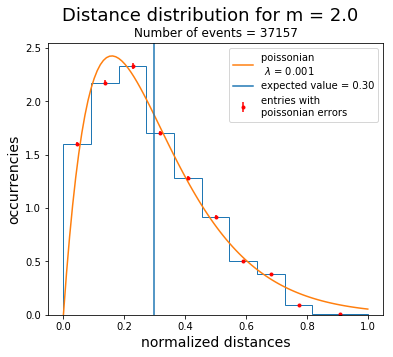

For m = 2.25 and N = 22268 the minimum number of events in the tail required is : 28
Minimum accuracy expected : 0.81
Number of bins merged into the tail: 1 



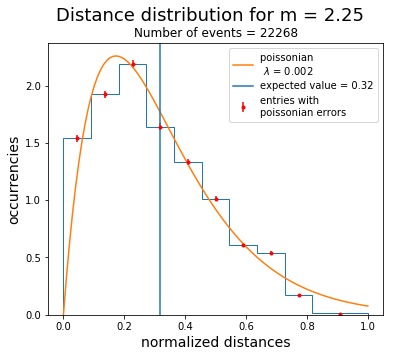

For m = 2.5 and N = 12482 the minimum number of events in the tail required is : 20
Minimum accuracy expected : 0.78
Number of bins merged into the tail: 1 



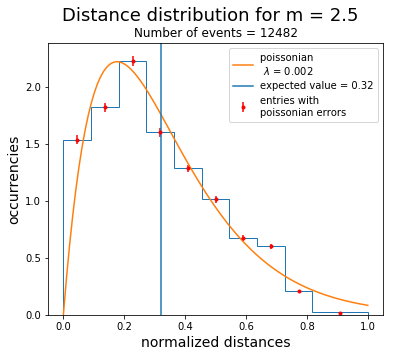

For m = 2.75 and N = 6848 the minimum number of events in the tail required is : 14
Minimum accuracy expected : 0.73
Number of bins merged into the tail: 1 



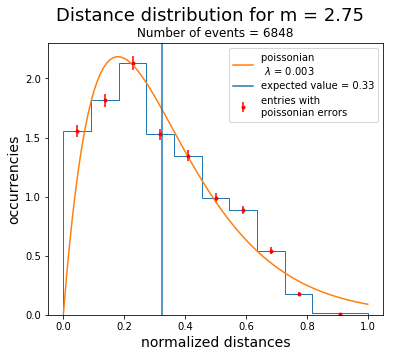

For m = 3.0 and N = 3567 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 



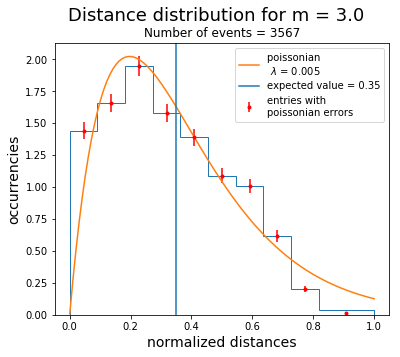

For m = 3.25 and N = 1866 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 



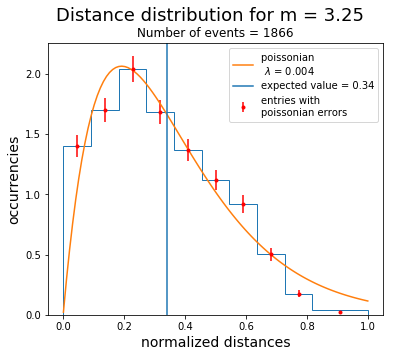

For m = 3.5 and N = 993 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 1 



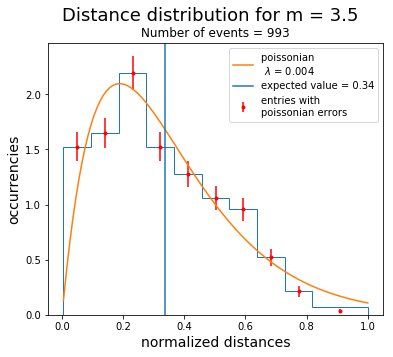

For m = 3.75 and N = 555 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 2 



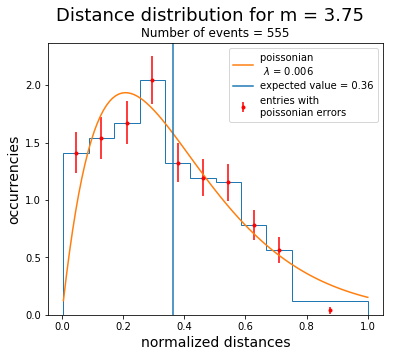

For m = 4.0 and N = 300 the minimum number of events in the tail required is : 10
Minimum accuracy expected : 0.68
Number of bins merged into the tail: 3 



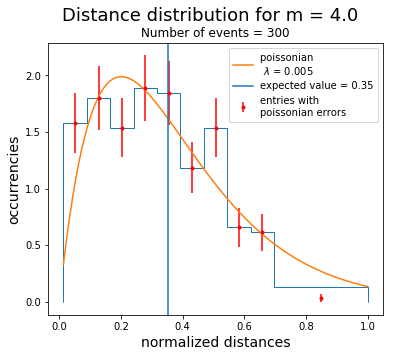

In [21]:
pr_r_expected, pr_r_exp_err, pr_r_max, pr_ms = E.PrimeEventsDistanceDistributionPlot(df)

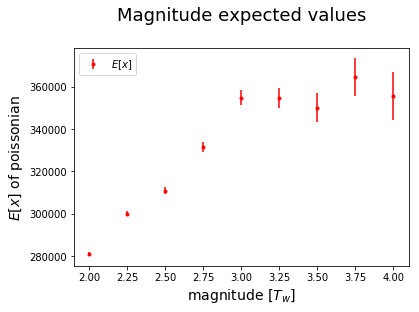

In [22]:
E.ExpectedMagnitudePlot(pr_r_expected, pr_r_exp_err, pr_r_max, pr_ms)

In the graph we can see that the expected value of the distance between two events grows linearly as a function of the magnitude until $m = 3.0$, where there is a plateau, indicating some kind of saturation effect. 

## 3.2 - Distance distribution between consequent events

In [38]:
distance_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            distance_tree[int(j)] = np.linalg.norm(df[['x','y','z']].iloc[int(j)] - df[['x','y','z']].iloc[int(k)])

distance_tree = distance_tree[distance_tree > 0]

In the panels below we can see that for consequent events we find once again a powerlaw with a cut-off, just like in the waiting times distribution, even though in this case our analysis can't be performed for all the magnitudes, because this would break the chain of cause-effect that is necessary to the algorithm itself to compute the waiting times.

Merging first and second bins.


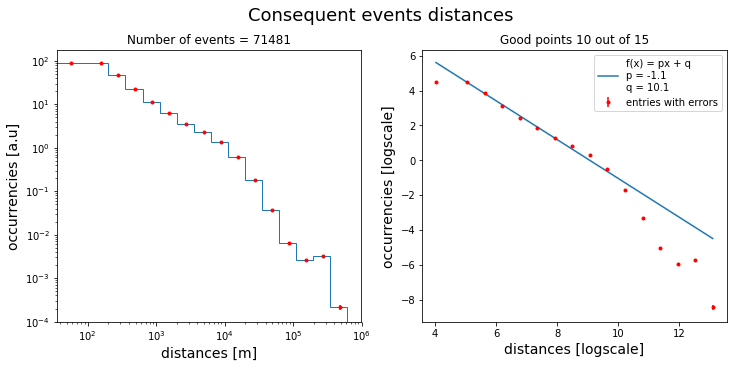

In [39]:
out = E.plot_powerlaw_hist_dist(distance_tree, suptitle = "Consequent events distances", rescaling = False, density = False, cut_off = True)

Summing up all the pieces of information that we gained in this section we can have an insight of the distance distribution big picture:

- following events have an internal order and their distance distribution is peaked around $R = 0$;
- random pair distances have a qualtatively different distribution, that presents a peak for $R > 0$;
- prime events are distributed with a poisson distribution (that has a peak for $R > 0$);
- consequent events display a powerlaw with cutoff.


Our analysis couldn't detect any coherent scaling property for all magnitudes, but we can not exclude this eventuality because the ordering procedure of the events influences the distribution itself and a more strict ordering criterium, like consequential order, shows indeed a powerlaw. 

Thus a possible development in this direction could be to take into account a possible graph structure for each magnitude, like the acyclic directed graph that we constructed for the consequent events.


## 4 - Range-conditioned waiting time distribution

In this section we want to study the distribution of the waiting times (Sec. 2) adding an ulterior constraint, that is that the distance between two events should be less than $R$, for different values of $R$. We denote this probability distribution as $P_{m,R}(t)$.

In our analysis we choose to analyze the waiting times distribution for different areas around $n$ fixed centers (uniformly distributed in the plane identified with the PCA procedure).
We proceed as follows: 
* we filter the dataset with the threshold magnitude > m;
* for each center $C_i$ and each radius $r_j$ (expressed in fractions of the maximum distance between two events in the dataset) we select only the events whose normalized distance (w.r.t. the max distance) from $C_i$ is less than $r_j$; 
* we compute the waiting times from each event to the following one among the remaining (again this is done for n centers and for each radius);
* we make a histogram using all the waiting times for a given radius and ALL centers (in this way the resulting distribution is a kind of mean among all centers) and study it as a powerlaw with cutoff (after all is derived from the waiting time distribution seen above, that is a powerlaw with cutoff too).

In [1]:
from tqdm import tqdm_notebook, tnrange
importlib.reload(E)

R_fractions = 20
ms = np.arange(2,4.6,0.1)
Rs = np.power(np.linspace(np.sqrt(0.03),1,R_fractions),2)
Ps = np.zeros((len(ms),R_fractions))
Qs = np.zeros((len(ms),R_fractions))
P_errors = np.zeros((len(ms),R_fractions))
t_cutoff = np.zeros((len(ms),R_fractions))

for i in tnrange(len(ms)):
    Ps[i], Qs[i], P_errors[i], t_cutoff[i] = E.plot_PmR_t(df, ms[i], U, Rs, n = 200, cut_off = True, 
                                                          P0 = 5, show = True, verbose = False)

NameError: name 'importlib' is not defined

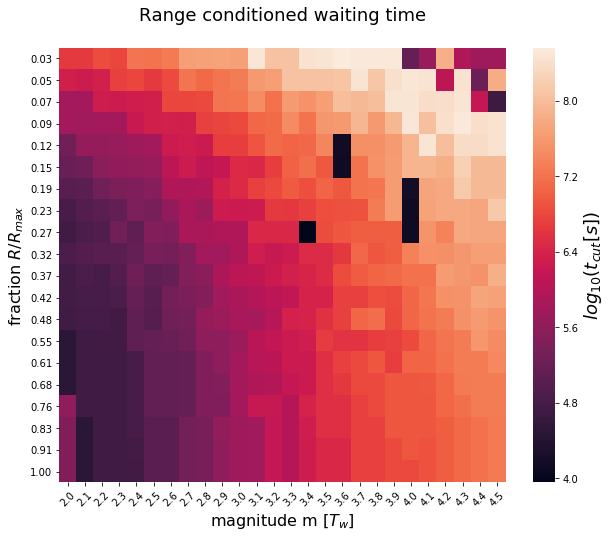

In [43]:
E.RangeMagnitudePlot(ms, Rs, t_cutoff)

From our analysis of the cutoff times at different radii and magnitudes we can see that there are two different trends: 
* the cutoff waiting time increases as the magnitude increases (as we saw before with the exponential dependence from m)
* the cutoff waiting time increases as the radius decreases

The second trend can be interpreted as the fact that background (uncorrelated) events are more rare if we reduce the area of study and this implies a longer correlation time between earthquakes in that reduced area (if the magnitude is fixed).

We have already seen how the cutoff waiting time depends on the magnitude, now we are going to study the relation between the waiting time and the radius.


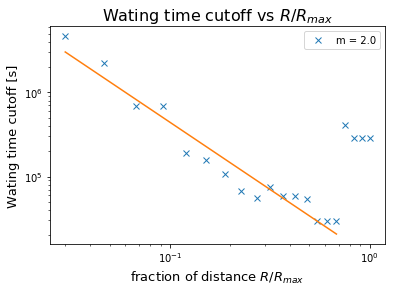

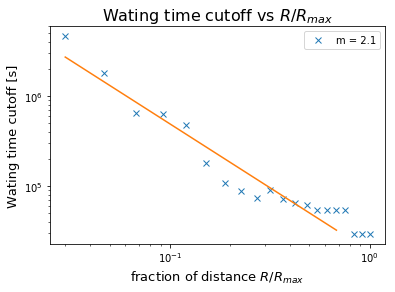

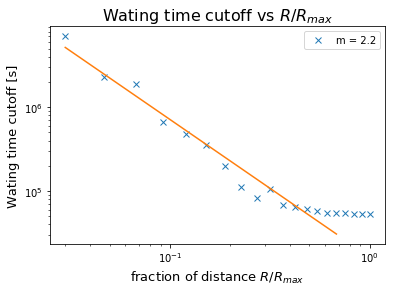

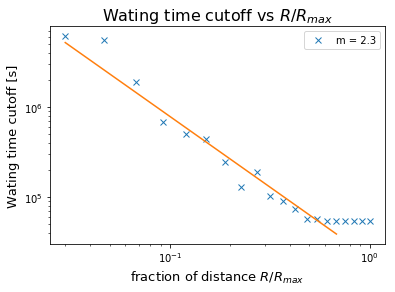

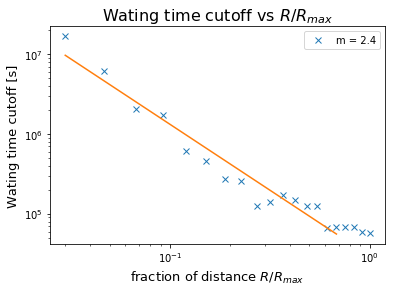

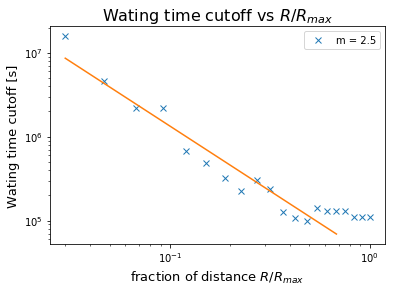

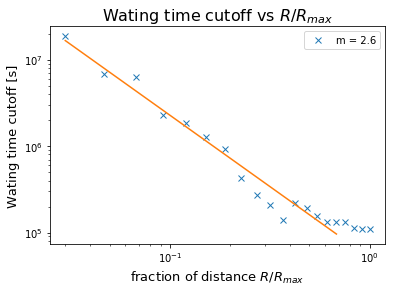

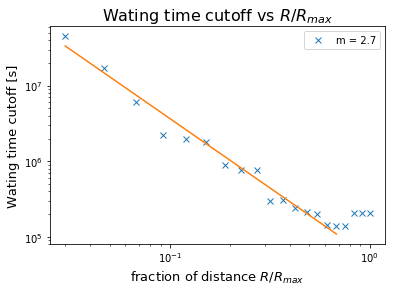

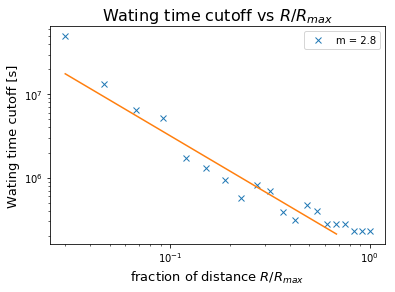

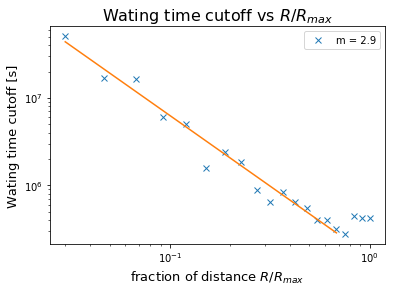

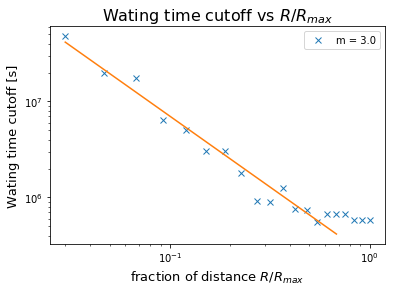

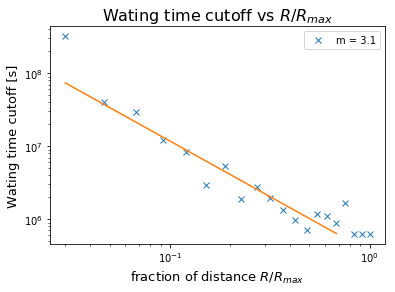

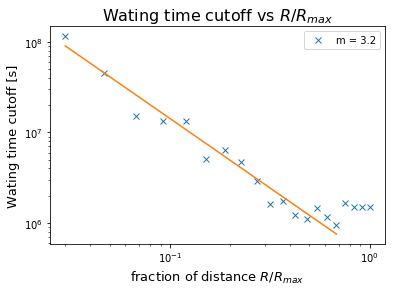

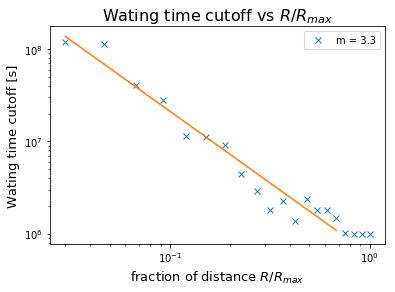

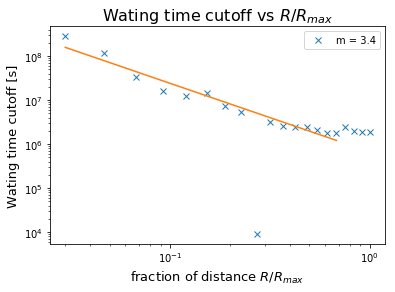

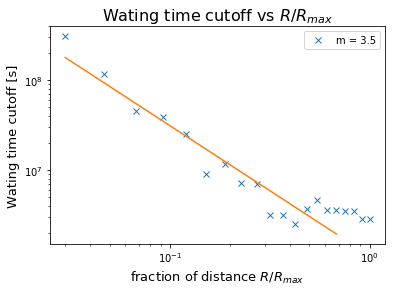

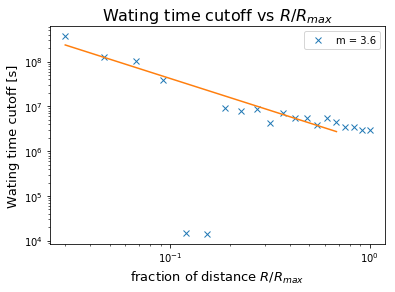

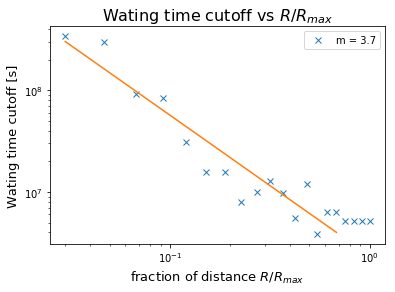

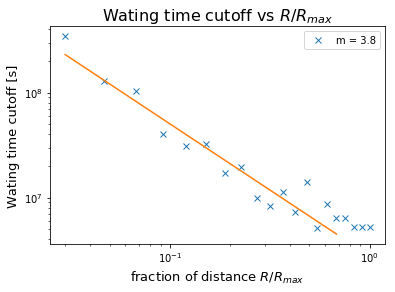

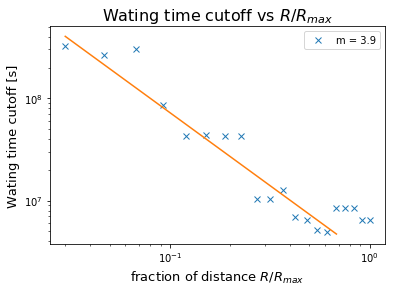

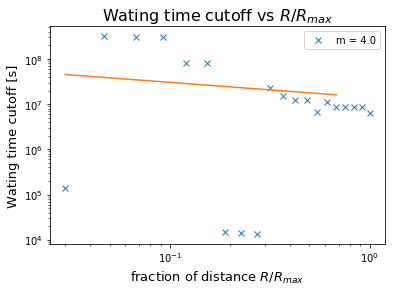

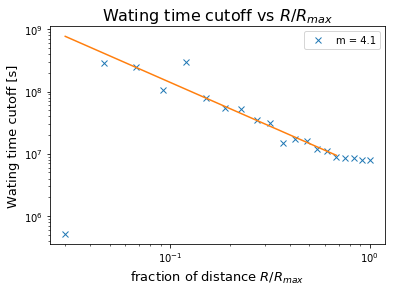

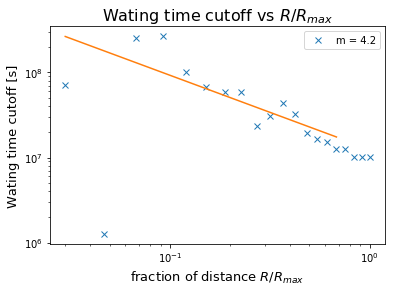

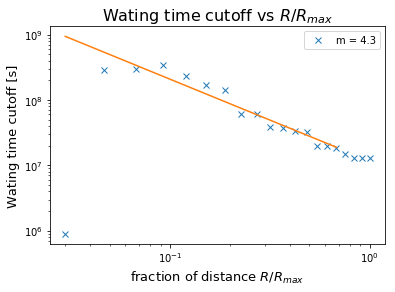

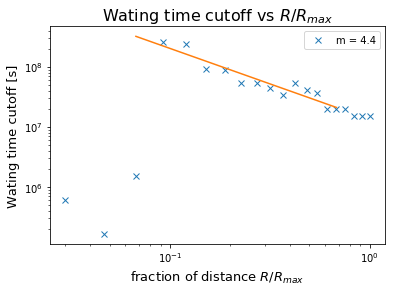

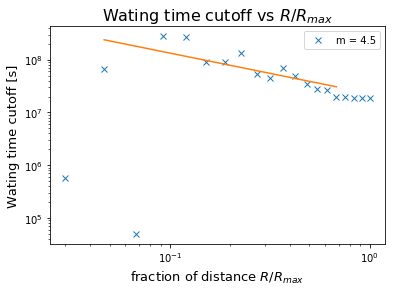

In [46]:
# It is show a specific plot using 'show = m' (or write 'True' to see all of them)
R_scaling_params = E.Tcutoff_over_R_plots(t_cutoff, Rs, ms, show=True)

# It is possible to fit t_cutoff and m for every R/R_max
#_ = E.Tcutoff_over_m_plots(t_cutoff, Rs, ms, show=True)

Notice that the truncation is justified by the fact that the dataset is limited to the events in South California, thus in most cases, when the considered area is the one included in a radius of $R_{max}$, the effective waiting times would be lower than the one computed if only the dataset wasn't geographically limited (in an artificial/arbitrary way).

# 5 - Scaling properties


In this last section we want to review the scaling properties of the system under exam.

As we said before, the scaling phenomenon happens if two conditions are verified:
* the system is scale-free, i.e. it doesn't have any characteristic scale in the distribution of a given quantity, except a "correlation length" (that for example for the waiting times is given by the cutoff time);
* the exponent of the distribution is the same for all distributions.

More in concrete, if we have a distribution of a variable $\mathbf{x}$ (waiting time or distance) which scales in another variable $y$ (magnitude threshold or area of observation), to obtain the rescaled distribution $P(z)$ from $P_y(\mathbf{x}) = \mathbf{x}^{\delta} \cdot f(\mathbf{x}/\mathbf{x}_{cut}(y))$ we have to divide $\mathbf{x}$ for $\mathbf{x}_{cut}$ and multiply $P_y(\mathbf{x})$ for $\mathbf{x}_{cut}(y)$  (so that the distribution remains normalized).

In this way we obtain a unique powerlaw with critical exponent $\delta$ with a cutoff independent from the $y$. 

## 5.1 - Time scaling with magnitude

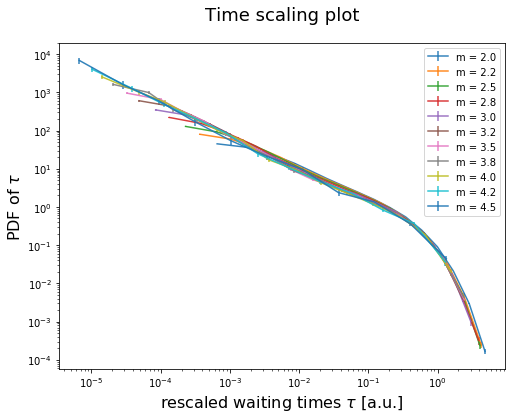

In [47]:
E.ScalingPlot(df, ms1, cut_times)

## 5.2 - Range-Conditioned Time scaling with magnitude

Now we try to see if for the same m we can derive a single collapsed curve for all different R.
Denoting $r = R/R_{max}$, we have 

$log(t_{cut}) = \alpha \cdot log(r) + \beta \rightarrow t_{cut}(r) = e^\beta r^{\alpha}$

Given the fact that each cutoff time is obtained from a condition both on m and r, and that the coefficient $\alpha$  is the same for all the distributions (because of the scaling that we are going to see), the dependence on m must be contained in $\beta$.

In section 2, we have seen that the cutoff scales exponentially in m, thus we expect the same for $t \propto e^{\beta(m)}$. In the left panel below we show that this behaviour is met, whereas in the right panel we compare the two trends for the cutoff waiting time as a function of m for $r=1$. The different slope means that in this second method we find a smaller estimate of the cutoff waiting times for smaller m.

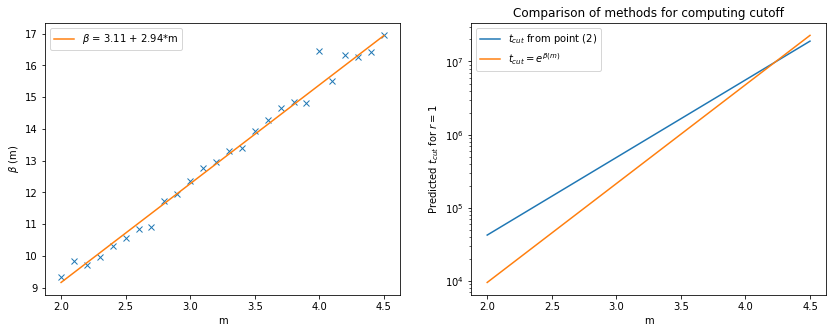

In [48]:
E.Compare_scaling_methods(ms, R_scaling_params, scaling_params)

In [49]:
rescaled_histograms = E.compute_every_rescaled_hist(df, Rs, ms, R_scaling_params, U)

In this last plot we show the rescaled distribution probabilitiesfor a fixed $r$ and different magnitudes.

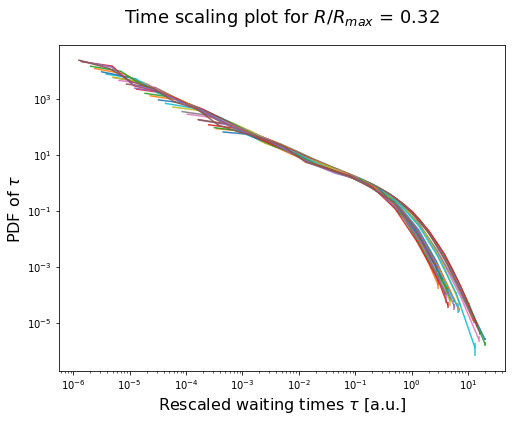

In [50]:
E.ScalingPlot_single_R(rescaled_histograms, ms, Rs, R_fraction=0.3)
#E.ScalingPlot_single_m(rescaled_histograms, ms, Rs, m = 4.3)

# Conclusions

In this project we analized the South California earthquakes dataset, focusing in particular on the waiting times and the distances distributions.
We were able to show that the waiting times distributions have the shape of a powerlaw $P(\tau) = \tau^{-\delta}$ with $\delta = 0.88$ and with a cutoff. Futhermore, they have a scaling property that depends both on the magnitude threshold and the spatial area considered. 

The distances distributions instead can be decomposed in a continuous poisson distribution for prime events and a powerlaw with cutoff for consequent events. Our analysis couldn't detect any global scaling for all distances distributions, but our results for the consequent events distribution suggest that taking into account a causal structure of the earthquakes network for all magnitudes could provide an ordering procedure to retrieve powerlaw distribution also for distances.
